Under the broad category of demand forecasting, I plan to investigate the times of day during which PLAICraft sees the highest traffic. I will mainly work with the `sessions` dataset, but I will join this with the `players` database to allow investigation of demographics - whether demand is different for different age ranges. 

In [1]:
#loading libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(janitor)
options(repr.matrix.max.rows = 10)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Upon inspection, the `players` dataset, in which each observation is a unique player, contains the following variables:
- `experience`, the self-reported experience level of each player
- `subscribe`, whether the player subscribed to a database
- `hashedEmail`, a unique, untraceable identifier derived from the player's email
- `played_hours`, how long they played PLAICraft, in hours
- `gender`, their self-reported gender identity
- `Age`, their self-reported age in years

Data for 196 unique players is included in this dataset.

`sessions`, in which each observation is a play session contains:
- `hashedEmail` of the player who played the session
- `start_time` and `end_time`, timestamps for the beginning and end of the play session
- `original_start_time` and `original_end_time`, number of seconds between January 1, 1970, and the beginning/end of the play session

Data for 1535 play sessions is included in this dataset.

In [16]:
sessions_url <- "https://raw.githubusercontent.com/YoyoLiu314/group-project/refs/heads/main/sessions.csv"
players_url <- "https://raw.githubusercontent.com/YoyoLiu314/group-project/refs/heads/main/players.csv"

players <- read_csv(players_url) 

sessions <- read_csv(sessions_url) 

sessions
players

names <- players |> #Confirming that the names are unique
    group_by(name) |>
    summarize(count = n()) |>
    select(count) |>
    map_df(max)
names
#As the max value for "count" is 1, there is no name associated with more than one row/player.

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
⋮,⋮,⋮,⋮,⋮
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,10/05/2024 23:01,10/05/2024 23:07,1.71538e+12,1.71538e+12
7a4686586d290c67179275c7c3dfb4ea02f4d317d9ee0e2cee98baa27877a875,01/07/2024 04:08,01/07/2024 04:19,1.71981e+12,1.71981e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,TRUE,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,0.0,Bailey,Female,17
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17


count
<int>
1


Immediately, a few tidiness issues are obvious. Column titles have inconsistent capitalization and word spacing conventions, some variables are the wrong data type, and the UNIX time is not precise enough to be useful. Hence, the useless columns are removed, column names are cleaned, and types are changed.

In [17]:
sessions <- read_csv(sessions_url) |> #For some reason, I need to read the code in again or this doesn't work. 
    clean_names() |> #I don't have time to figure out why so I'll just appease the R gods.
    mutate(start_time = dmy_hm(start_time)) |>
    mutate(end_time = dmy_hm(end_time)) |>
    select(-starts_with("original")) 

players <- players |>
clean_names() |>
mutate(experience = as_factor(experience))

sessions
players

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashed_email,start_time,end_time
<chr>,<dttm>,<dttm>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-30 18:12:00,2024-06-30 18:24:00
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-17 23:33:00,2024-06-17 23:46:00
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-07-25 17:34:00,2024-07-25 17:57:00
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-07-25 03:22:00,2024-07-25 03:58:00
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-25 16:01:00,2024-05-25 16:12:00
⋮,⋮,⋮
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-10 23:01:00,2024-05-10 23:07:00
7a4686586d290c67179275c7c3dfb4ea02f4d317d9ee0e2cee98baa27877a875,2024-07-01 04:08:00,2024-07-01 04:19:00
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2024-07-28 15:36:00,2024-07-28 15:57:00


experience,subscribe,hashed_email,played_hours,name,gender,age
<fct>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,TRUE,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,0.0,Bailey,Female,17
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17


The `experience` and `subscribe` variables are not relevant to this project. Generating some relevant summary statistics on the `player` variables to learn a little about the demographics:

In [4]:
means <- players |>
    select(played_hours, age) |>
    map_df(mean, na.rm = TRUE) |>
    rename(mean_played_hours = played_hours, mean_age = age)

max_vals <- players |>
    select(played_hours, age) |>
    map_df(max, na.rm = TRUE) |>
    rename(max_played_hours = played_hours, max_age = age)

min_vals <- players |>
select(played_hours, age) |>
    map_df(min, na.rm = TRUE) |>
rename(min_played_hours = played_hours, min_age = age)

ranges <- bind_cols(min_vals, means, max_vals) 
ranges


min_played_hours,min_age,mean_played_hours,mean_age,max_played_hours,max_age
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,8,5.845918,20.52062,223.1,50


Considering the sessions data now, we can determine the timespan over which the data was collected, the average length of a session, and how many sessions each player played. As seen below, data collection took place over about 6 months, from early April to late September.

In [5]:
date_range <- summarize(sessions, start_collection = min(start_time, na.rm = TRUE), end_collection = max(end_time, na.rm = TRUE))
date_range #na.rm = TRUE is required as one session has no recorded end time (may have been ongoing when data collection was stopped)



start_collection,end_collection
<dttm>,<dttm>
2024-04-06 09:27:00,2024-09-26 07:39:00


The average session lasted a bit under an hour, the shortest lasting just 3 minutes and the longest, over 4 hours.

In [6]:
max_session_time <- sessions |>
    mutate(duration = end_time - start_time) |>
    select(duration) |>
    map_df(max, na.rm = TRUE) |>
    rename(max_duration = duration)

min_session_time <- sessions |>
    mutate(duration = end_time - start_time) |>
    select(duration) |>
    map_df(min, na.rm = TRUE) |>
    rename(min_duration = duration)

mean_session_time <- sessions |>
    mutate(duration = end_time - start_time) |>
    select(duration) |>
    map_df(mean, na.rm = TRUE) |>
    rename(mean_duration = duration)

bind_cols(min_session_time, mean_session_time, max_session_time)



min_duration,mean_duration,max_duration
<drtn>,<drtn>,<drtn>
3 mins,50.85845 mins,259 mins


We can count how many times each hashed email appears in `sessions` and use `inner_join()` to associate them with player names and information. This provides a couple insights:
1. As this new data frame has only 125 rows, while `player` has 196, 71 players registered but never played the game.

In [7]:
sessions_counts <- sessions |>
group_by(hashed_email) |>
summarize(count = n()) 

sessions_players <- inner_join(players, sessions_counts) |>
select(name, gender, age, played_hours, count) |>
arrange(-count) 

top_players <- sessions_players |>
head(10)
top_players

Joining with `by = join_by(hashed_email)`


name,gender,age,played_hours,count
<chr>,<chr>,<dbl>,<dbl>,<int>
Dana,Male,23,56.1,310
Hiroshi,Male,17,223.1,219
Delara,Female,16,150.0,159
Piper,Female,19,178.2,147
Alex,Male,17,53.9,130
Akio,Non-binary,20,218.1,95
Sidney,Male,22,32.0,79
Arash,Male,17,7.1,47
Kyrie,Male,14,17.2,41


2. While the mean number of sessions played is around 12, the histogram shows that the vast majority of players played 0-5 sessions, but the mean is increased by outliers who played hundreds of sessions. Note that there are only about 1500 recorded sessions, meaning the top two players represent one third of all the sessions played and the top five represent well over half of the sessions. Hence, any further conclusions drawn about high-traffic times will likely be skewed towards the play time preferences of these players.

average_session_count
<dbl>
12.28


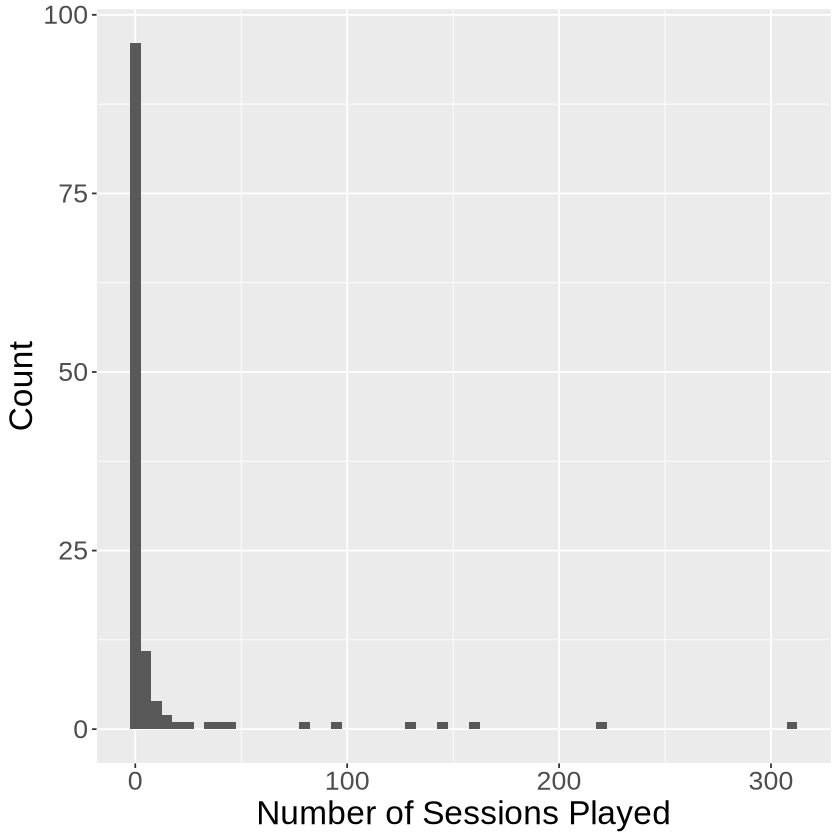

In [8]:
avg_sessions <- sessions_players |>
    select(count) |>
    map_df(mean, na.rm = TRUE) |>
    rename(average_session_count = count)
avg_sessions

sessions_histogram <- ggplot(sessions_players, aes(x = count)) +
    geom_histogram(binwidth = 5) +
    labs(x = "Number of Sessions Played", y = "Count") +
    theme(text = element_text(size = 20))
sessions_histogram


**SPECIFIC QUESTION**: I aim to determine if we can predict time periods of high PLAICraft traffic, combining data for the time of day as well as the time of year, from the data set provided. We can first examine patterns in the distribution of sessions played over time. The frequency plot over the entire data collection period shows that the most sessions were played in the sumnmer months (July), tapering off in other months. 

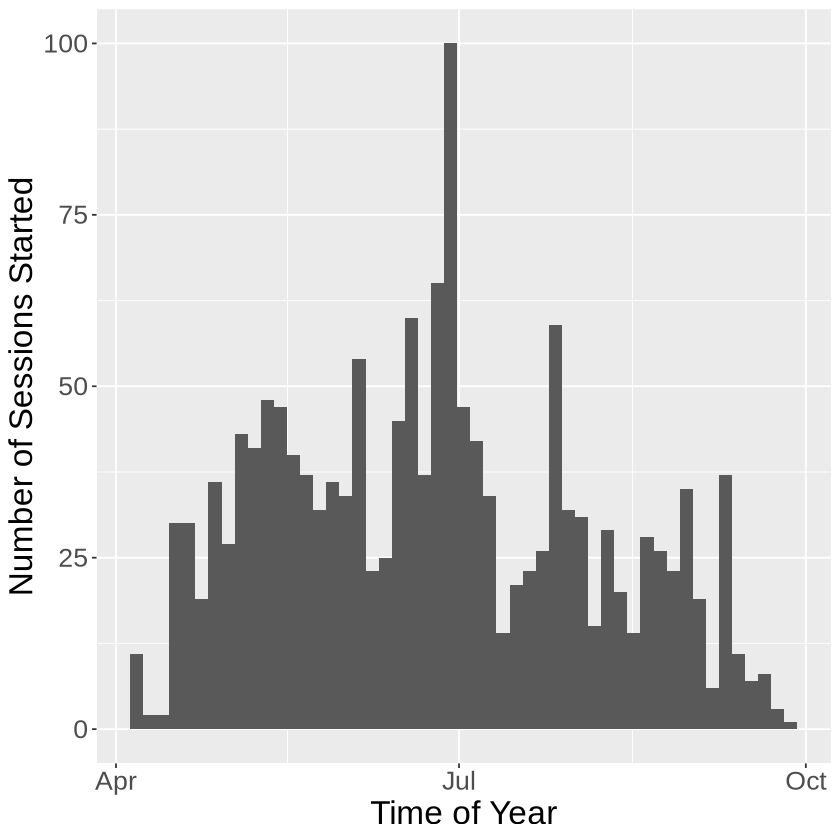

In [31]:
time_plot <- sessions |>
    ggplot(aes(x = start_time)) +
        geom_histogram(binwidth = 300000) +
    labs(x = "Time of Year", y = "Number of Sessions Started") +
    theme(text = element_text(size = 20))

time_plot

Over a single day, it seems that the fewest sessions are played at midday, with most sessions being played early in the morning or late at night. Again, note that this may be skewed by our "power users" and thus a poor representation of the population.

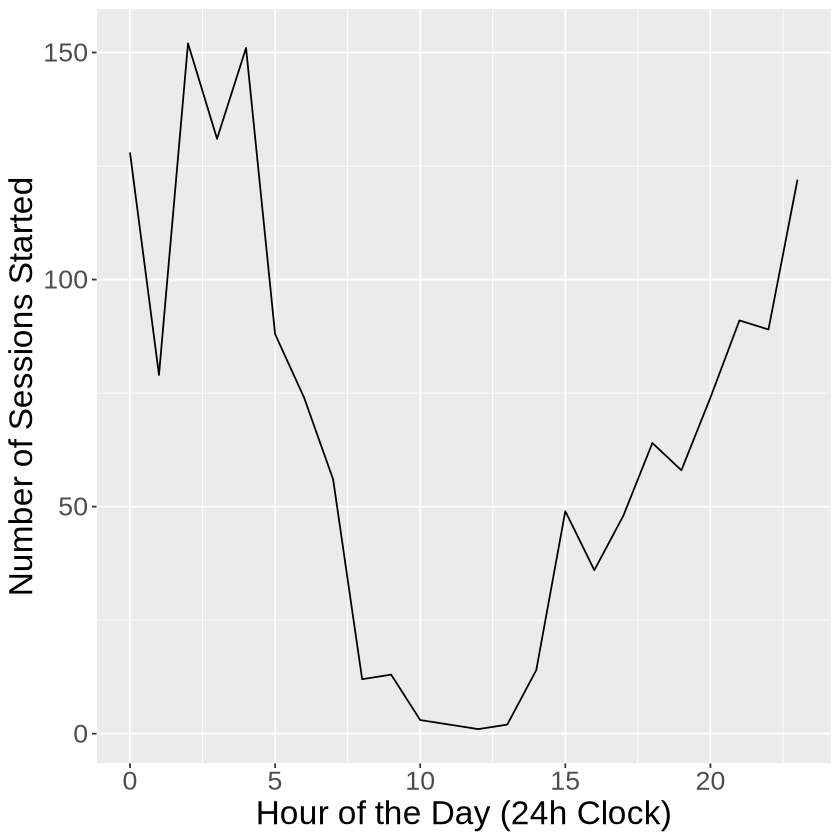

In [26]:
daily_plot <- sessions |> 
mutate(hour = hour(start_time)) |> 
group_by(hour) |> 
summarize(count = n()) |> 
ggplot(aes(x = hour, y = count)) + 
geom_line() +
labs(x = "Hour of the Day (24h Clock)", y = "Number of Sessions Started") +
    theme(text = element_text(size = 20))
daily_plot

**Methods and Plan:**

While some patterns can be seen in the visualizations produced, these visualizations are not yet useful for predicting demand. Using bootstrapping, we can approach the problem inferentially, aiming to determine the time range over which 95% of sessions take place. We can again split the `session` data and see if close to 95% of the sessions in the testing split actually do fall within that time range. (We could also use KNN regression with date and time as predictors, but this is less useful for the purposes of demand forecasting).

This model requires time to be treated numerically, but it is cyclic - the difference in time of day between 86400 s and 86401 seconds is equal to the difference between 86400 s and 1 s. Given what is seen in the line plot above, we may be able to center the bootstrapping distribution at 00h00 to generate a bell curve. Regardless, if we plot a distribution over a day, the two ends will not be extremes but will actually be the exact same time.

There is also the issue of considering how to treat the durations of sessions. The above visualizations only consider the start time of a session, while the necessary traffic depends on how many sessions are ongoing at any given time. Either the model will need to assume that all sessions run a similar duration at all times, or it will have to determine the number of sessions ongoing at a certain time of day rather than the number of sessions started at that time. 

Above all, any model will require the assumption that the dataset is representative of the wider population. This may very well not be the case, as previously stated, but analysis can still be carried out using this data.